# Imports

To try:

Model on entire dataset, model uncertainty estimated by smearing entire dataset

In [186]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

In [2]:
print(tf.__version__)

2.2.0


In [3]:
import scipy.optimize as optimization

from BHDVCStf import BHDVCS #modified bhdvcs file
bhdvcs = BHDVCS()

# Data

In [4]:
class DvcsData(object):
    def __init__(self, df):
        self.X = df.loc[:, ['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'ReH', 'ReE', 'ReHtilde', 'dvcs']]
        self.XnoCFF = df.loc[:, ['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'dvcs']]
        self.y = df.loc[:, 'F']
        self.Kinematics = df.loc[:, ['k', 'QQ', 'x_b', 't']]
        self.erry = df.loc[:, 'errF']
        
    def __len__(self):
        return len(self.X)
    
    def getSet(self, setNum, itemsInSet=36):
        pd.options.mode.chained_assignment = None
        subX = self.X.loc[setNum*itemsInSet:(setNum+1)*itemsInSet-1, :]
        subX['F'] = self.y.loc[setNum*itemsInSet:(setNum+1)*itemsInSet-1]
        subX['errF'] = self.erry.loc[setNum*itemsInSet:(setNum+1)*itemsInSet-1]
        pd.options.mode.chained_assignment = 'warn'
        return DvcsData(subX)
    
    def sampleY(self):
        return np.random.normal(self.y, self.erry)
    
    def sampleWeights(self):
        return 1/self.erry
    
    def getAllKins(self, itemsInSets=36):
        return self.Kinematics.iloc[np.array(range(len(df)//itemsInSets))*itemsInSets, :]

In [5]:
df = pd.read_csv("dvcs_xs_newsets_genCFFs.csv")
data = DvcsData(df)

In [6]:
numSets = df['#Set'].max()+1

In [7]:
numSets

15

# Produce replicas

I am using the baseline to fit replicas in this instance, but other methods can be easily substituted into the computeData function.

In [14]:
numReplicas = 100

In [16]:
def computeData(data, numSets, numReplicas):
    results = []
    for i in tqdm(range(numSets)):
        replicas = []
        seti = data.getSet(i)
        X = np.array(seti.XnoCFF)
        sigma = seti.erry
        pars = np.array([1, 1, 1])
        for i in range(numReplicas):
            y = seti.sampleY()
            cff, cffcov = optimization.curve_fit(bhdvcs.TotalUUXS, X, y, pars, sigma, method='lm')
            replicas.append(cff)
        results.append(replicas)
    return np.array(results)

In [17]:
results = computeData(data, numSets, numReplicas)

In [18]:
results.tofile('GlobalFit2Replicas.txt')

In [38]:
# results = np.fromfile('GlobalFit2Replicas.txt')
# results = results.reshape(numSets, numReplicas, 3)

In [19]:
results.shape

(15, 100, 3)

# Examine Replica accuracy

In [41]:
def evaluate(y_yhat):
    '''
    Provides a few model evaluation statistics from an array of true values and predictions.
    
    :param y_yhat: numpy array with first column being true values and second being predicted values.
    '''
    pct_errs = ((y_yhat[:, 0] - y_yhat[:, 1])/y_yhat[:, 1])*100
    print('Mean percent error: ', np.mean(np.abs(pct_errs)))

    RS = np.square((y_yhat[:, 0] - y_yhat[:, 1]))
    TS = np.square((y_yhat[:, 0] - y_yhat[:, 0].mean()))
    rmse = np.sqrt(np.mean(RS))
    rmtss = np.sqrt(np.mean(TS))
    print('RMSE: ', rmse)
    print('RMSE w yhat=mean: ', rmtss)
    RSS = np.sum(RS)
    TSS = np.sum(TS)
    print('R-squared: ', (1 - RSS/TSS))
    plt.hist(np.array(pct_errs))
    plt.title('Histogram of Percent Errors')
    plt.show()

In [53]:
y = results[:, :, 0].mean(axis=1)
yhat = df.loc[np.array(range(numSets))*36, 'ReH'].reset_index(drop=True)
y_yhat = np.transpose(np.array([list(y), list(yhat)]))

Mean percent error:  10.39472277431491
RMSE:  1.016593117128301
RMSE w yhat=mean:  2.233012731118498
R-squared:  0.7927416999621235


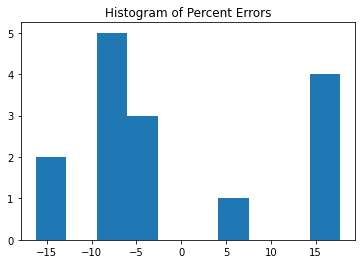

In [54]:
evaluate(y_yhat)

# ReH

# Global Model

Shape of results = (# of Kinematic Sets, # of Replicas, 3 CFFs)

CFFs are in order of: ReH, ReE, ReHtilde

In [55]:
results.shape

(15, 100, 3)

In [260]:
kinematics = tf.keras.Input(shape=(4))
x = tf.keras.layers.Dense(20, activation="relu")(kinematics)
outputs = tf.keras.layers.Dense(1)(x)

globalModel = tf.keras.Model(inputs=kinematics, outputs=outputs, name="GlobalModel")

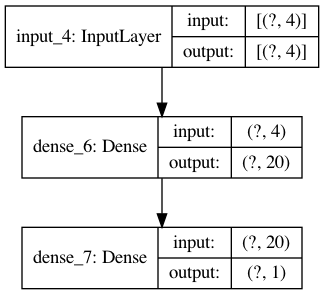

In [261]:
tf.keras.utils.plot_model(globalModel, "cffs.png", show_shapes=True)

## ReH model

In [58]:
whichCFF = 0 # ReH

In [71]:
X = df.loc[np.array(range(numSets))*36, ['k', 'QQ', 'x_b', 't']].reset_index(drop=True)

y = df.loc[np.array(range(numSets))*36, 'ReH'].reset_index(drop=True)

def produceEstimates(replica_models, valid_x):
    cffGuesses = []
    for model in replica_models:
        cffGuesses.append(model.predict(valid_x)[0][0])
    return np.array(cffGuesses)

In [131]:
rescaler = MinMaxScaler()

In [136]:
rescaler = rescaler.fit(X)

In [141]:
X_rescaled = rescaler.transform(X)

In [265]:
globalModel.compile(optimizer=tf.keras.optimizers.Adam(.3), loss=tf.keras.losses.MeanSquaredError())

In [266]:
orig_weights = globalModel.get_weights()

i = 4

valid_x = X_rescaled[[i], :]
train_x = np.delete(X_rescaled, i, axis=0)
valid_y = np.array(y[i])
train_y = np.delete(np.array(y), i, axis=0)

globalModel.set_weights(orig_weights)

globalModel.fit(train_x, train_y, epochs = 150, verbose=2)

globalModel.predict(valid_x)

# Assuming we know true values

In [79]:
def testWithTrue(globalModel, X, y, orig_weights, numSets):
    '''
    Essentially LOO cross-val with y-values being true
    
    globalModel: a tensorflow neural network model
    X: standardized kinematic variables
    y: the true values of a CFF for each kinematic set
    orig_weights: the original weights from when the model was created (used to reset model after it has been trained)
    numSets: the number of kinematic sets
    
    returns: averag rmse, list of percent errors from each set
    '''
    y_yhat = []
    for i in tqdm(range(numSets)):
        valid_x = X[[i], :]
        train_x = np.delete(X, i, axis=0)
        valid_y = y[i]
        train_y = np.delete(np.array(y), i, axis=0)
        
        if np.any(np.all(valid_x == train_x, axis=1)):
            raise Exception
        
        globalModel.set_weights(orig_weights)
        globalModel.fit(train_x, train_y, epochs = 150, verbose=0)
        pred = globalModel.predict(valid_x)[0][0]
        y_yhat.append([valid_y, pred])
            
    return np.array(y_yhat)

In [80]:
y_yhat = testWithTrue(globalModel, X_rescaled, y, orig_weights, numSets)

Mean percent error:  1.5851343572306809
RMSE:  0.18344692193093
RMSE w yhat=mean:  2.5254628436780107
R-squared:  0.9947235856637184


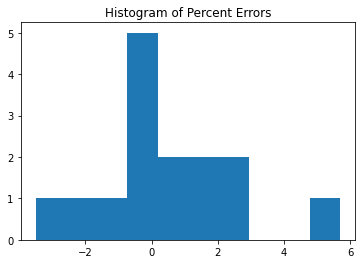

In [81]:
evaluate(y_yhat)

# With replicas

In [311]:
def testWithReplicas(model, X, y, results, orig_weights, numSets, numReplicas, whichCFF, epochs=150):
    '''
    Essentially LOO cross-val with y-values being generated from seperate local fit
    
    globalModel: a tensorflow neural network model
    X: standardized kinematic variables
    y: the true values of a CFF for each kinematic set
    orig_weights: the original weights from when the model was created (used to reset model after it has been trained)
    numSets: the number of kinematic sets
    numReplicas: the number of replicas
    whichCFF: which compton form factor to use
    
    returns: average rmse, list of percent errors from each set
    '''
    y_yhat = []
    for i in tqdm(range(numSets)):
        valid_x = X[[i], :]
        train_x = np.delete(X, i, axis=0)
        valid_y = np.array(y[i])
        
        preds = []
        for rep in range(numReplicas):
            train_y = np.delete(results[:, rep, whichCFF], i)
            
            model.set_weights(orig_weights)
            model.fit(train_x, train_y, epochs=epochs, verbose=0)
            preds.append(model.predict(valid_x)[0][0])
        
        pred = np.array(preds).mean()
        y_yhat.append([valid_y, pred])

    
    return np.array(y_yhat)

In [83]:
y_yhat = testWithReplicas(globalModel, X_rescaled, y, results, orig_weights, numSets, numReplicas, whichCFF)

Mean percent error:  7.660544718196133
RMSE:  0.9558417182287775
RMSE w yhat=mean:  2.5254628436780107
R-squared:  0.8567515284713871


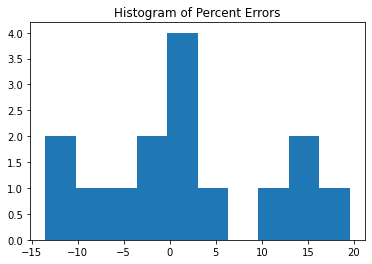

In [84]:
evaluate(y_yhat)

In [410]:
np.corrcoef(np.abs(pct_errs), np.abs(pct_errs_locals))[1, 0]

0.31606046817588396

## Predict across kinematic ranges

In [88]:
globalModel.set_weights(orig_weights)

In [94]:
X.describe()

,k,QQ,x_b,t
count,15.000000,15.000000,15.000000,15.000000
mean,5.883333,2.167642,0.390311,-0.323918
std,1.355764,0.266613,0.034070,0.044367
min,3.750000,1.740130,0.345012,-0.380868
25%,4.750000,2.036460,0.360829,-0.367341
50%,5.750000,2.073870,0.385579,-0.291599
75%,6.750000,2.179550,0.415563,-0.283318
max,7.750000,2.632580,0.436939,-0.278690


In [121]:
km = np.repeat([5.88333], 100)
QQm = np.repeat([2.167642], 100)
x_bm = np.repeat([.390311], 100)
tm = np.repeat([-.3239], 100)

k = np.linspace(3.75, 7.75, num=100)
QQ = np.linspace(1.74, 2.63, num=100)
x_b = np.linspace(.34, .44, num=100)
t = np.linspace(-.38, -.27, num=100)

In [127]:
to_pred = np.column_stack([k, QQm, x_bm, tm])
to_pred = np.vstack([to_pred, np.column_stack([km, QQ, x_bm, tm])])
to_pred = np.vstack([to_pred, np.column_stack([km, QQm, x_b, tm])])
to_pred = np.vstack([to_pred, np.column_stack([km, QQm, x_bm, t])])

In [146]:
to_pred = rescaler.transform(to_pred)

In [161]:
def predictwReplicas(model, X, to_pred, results, orig_weights, numReplicas, whichCFF):
    #valid_y = np.array(y[i])

    preds = []
    for rep in tqdm(range(numReplicas)):
        
        train_y = results[:, rep, whichCFF]

        model.set_weights(orig_weights)
        model.fit(X, train_y, epochs = 150, verbose=0)
        preds.append(model.predict(to_pred))
        
    return np.column_stack(preds)

In [179]:
preds = predictwReplicas(globalModel, X_rescaled, to_pred, results, orig_weights, numReplicas, whichCFF)

### plot of ReH as a function of k

In [180]:
def c_int_plot(preds, x, which_kin, kin_range, cffname):
    '''
    :param preds: numpy array of predictions
    :param x: an array of the values of which_kin that were used in generating predictions
    :param which_kin: string name of kinematic to plot
    :param kin_range: a tuple of lower and upper indices of predictions
    :param cffname: the name of the compton form factor we're predicting
    '''
    y_hat = preds[kin_range[0]:kin_range[1], :].mean(axis=1)
    upper_y_hat = y_hat + preds[kin_range[0]:kin_range[1], :].std(axis=1)
    lower_y_hat = y_hat - preds[kin_range[0]:kin_range[1], :].std(axis=1)
    
    plt.plot(x, lower_y_hat)
    plt.plot(x, y_hat, color='black')
    plt.plot(x, upper_y_hat, color='red')
    plt.title('68% confidence interval with point predictions')
    plt.ylabel(cffname)
    plt.xlabel(which_kin)
    plt.show()
        

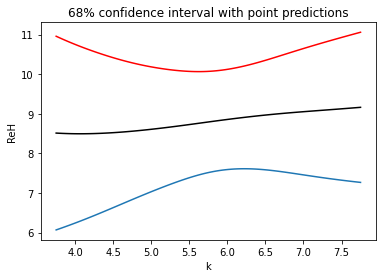

In [181]:
c_int_plot(preds, k, 'k', (0, 100), 'ReH')

### plot of ReH as a function of QQ

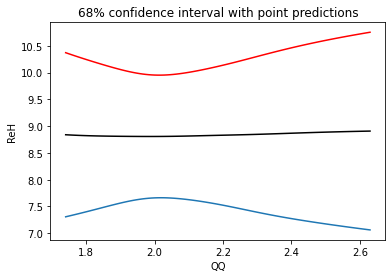

In [182]:
c_int_plot(preds, QQ, 'QQ', (100, 200), 'ReH')

### plot of ReH as a function of x_b

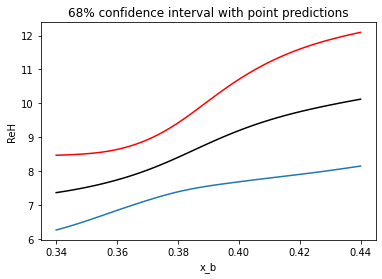

In [183]:
c_int_plot(preds, x_b, 'x_b', (200, 300), 'ReH')

## plot of ReH as a function of t

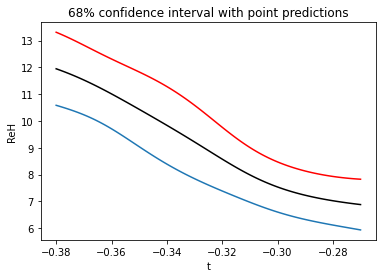

In [185]:
c_int_plot(preds, t, 't', (300, 400), 'ReH')

# ReE Model

Evaluate fits

In [390]:
whichCFF = 1 # ReE

Mean percent error:  11.057921264644353
RMSE:  5.675738319631367
RMSE w yhat=mean:  2.525480507907797
R-squared:  -4.050759464517492


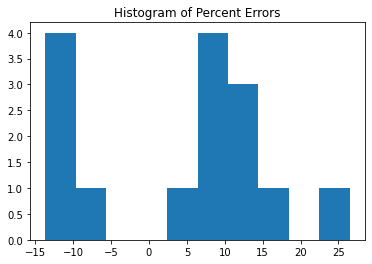

In [370]:
yhat = results[:, :, whichCFF].mean(axis=1)
y = df.loc[np.array(range(numSets))*36, 'ReE'].reset_index(drop=True)
y_yhat = np.transpose(np.array([list(y), list(yhat)]))

evaluate(y_yhat)

Global model

In [439]:
kinematics = tf.keras.Input(shape=(4))
x = tf.keras.layers.Dense(20, activation="relu")(kinematics)
outputs = tf.keras.layers.Dense(1)(x)

globalModel = tf.keras.Model(inputs=kinematics, outputs=outputs, name="GlobalModel")

In [440]:
orig_weights = globalModel.get_weights()

In [441]:
globalModel.compile(optimizer=tf.keras.optimizers.Adam(1), loss=tf.keras.losses.MeanSquaredError())

In [442]:
y = df.loc[np.array(range(numSets))*36, 'ReE'].reset_index(drop=True)

Evaluate with trues

In [443]:
y_yhat = testWithTrue(globalModel, X_rescaled, y, orig_weights, numSets)

Mean percent error:  0.6742199601519058
RMSE:  0.962998960769753
RMSE w yhat=mean:  2.525480507907797
R-squared:  0.8546002716611565


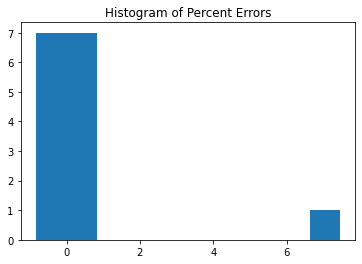

In [444]:
evaluate(y_yhat)

Evaluate with replicas

In [446]:
y_yhat = testWithReplicas(globalModel, X_rescaled, y, results, orig_weights, numSets, 25, whichCFF)

Mean percent error:  7.833792630760046
RMSE:  4.764762239000507
RMSE w yhat=mean:  2.525480507907797
R-squared:  -2.5595445005755675


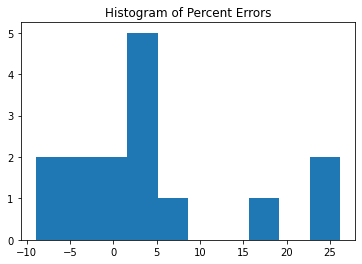

In [448]:
evaluate(y_yhat)

# ReHtilde Model

Evaluate fits

In [454]:
whichCFF = 2 # ReE

Mean percent error:  7.992647189510513
RMSE:  0.42766634278934085
RMSE w yhat=mean:  1.4030345621243816
R-squared:  0.9070876581634342


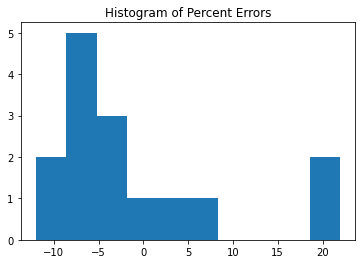

In [455]:
yhat = results[:, :, whichCFF].mean(axis=1)
y = df.loc[np.array(range(numSets))*36, 'ReHtilde'].reset_index(drop=True)
y_yhat = np.transpose(np.array([list(y), list(yhat)]))

evaluate(y_yhat)

Global model

In [464]:
kinematics = tf.keras.Input(shape=(4))
x = tf.keras.layers.Dense(20, activation="tanh")(kinematics)
outputs = tf.keras.layers.Dense(1)(x)

globalModel = tf.keras.Model(inputs=kinematics, outputs=outputs, name="GlobalModel")

In [465]:
orig_weights = globalModel.get_weights()

In [466]:
globalModel.compile(optimizer=tf.keras.optimizers.Adam(.1), loss=tf.keras.losses.MeanSquaredError())

In [467]:
y = df.loc[np.array(range(numSets))*36, 'ReHtilde'].reset_index(drop=True)

Evaluate with trues

In [468]:
y_yhat = testWithTrue(globalModel, X_rescaled, y, orig_weights, numSets)

Mean percent error:  0.46323659974615955
RMSE:  0.03430369780342113
RMSE w yhat=mean:  1.4030345621243816
R-squared:  0.9994022148302112


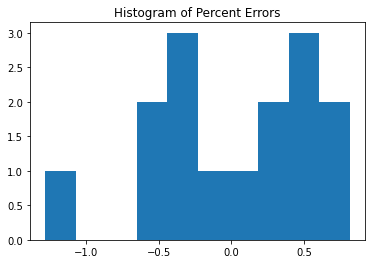

In [469]:
evaluate(y_yhat)

Evaluate with replicas

In [470]:
y_yhat = testWithReplicas(globalModel, X_rescaled, y, results, orig_weights, numSets, numReplicas, whichCFF)

Mean percent error:  6.3013921189053965
RMSE:  0.37462442522102163
RMSE w yhat=mean:  1.4030345621243816
R-squared:  0.9287055964174232


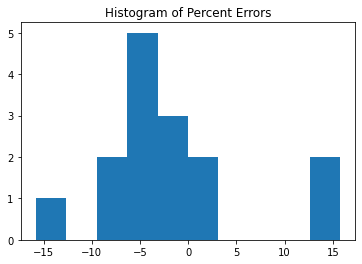

In [471]:
evaluate(y_yhat)

## Predictions

In [474]:
preds = predictwReplicas(globalModel, X_rescaled, to_pred, results, orig_weights, numReplicas, whichCFF)

### plot of k as a function of k

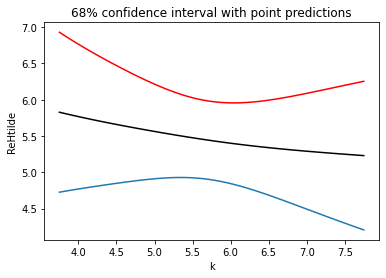

In [475]:
c_int_plot(preds, k, 'k', (0, 100), 'ReHtilde')

### plot of ReH as a function of QQ

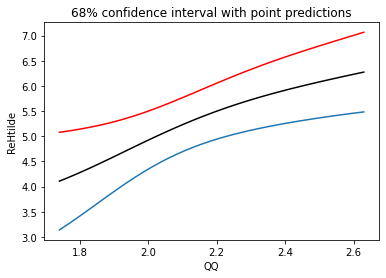

In [476]:
c_int_plot(preds, QQ, 'QQ', (100, 200), 'ReHtilde')

### plot of ReH as a function of x_b

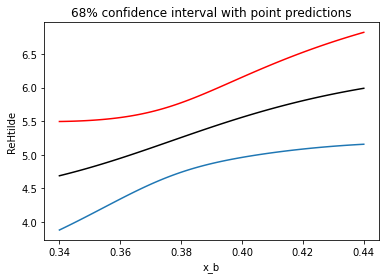

In [477]:
c_int_plot(preds, x_b, 'x_b', (200, 300), 'ReHtilde')

## plot of ReH as a function of t

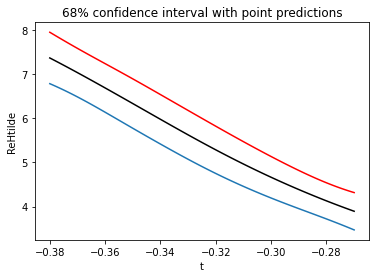

In [478]:
c_int_plot(preds, t, 't', (300, 400), 'ReHtilde')